# Homework 4
https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/04-evaluation/homework.md

In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
# df.lead_source.value_counts()

In [6]:
categorical_cols = []
numerical_cols = []

In [7]:
for i in df.columns:
    if df.dtypes[i] in ['int64', 'float64'] and i != 'converted':
        numerical_cols.append(i)
    elif df.dtypes[i] == 'object':
        categorical_cols.append(i)

In [8]:
print(numerical_cols)
print(categorical_cols)

['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
['lead_source', 'industry', 'employment_status', 'location']


In [9]:
for i in categorical_cols:
    df[i] = df[i].fillna('NA')
for i in numerical_cols:
    df[i] = df[i].fillna(0)
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [13]:
max_score = -9999.99
for i in numerical_cols:
    score = roc_auc_score(y_train, df_train[i])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[i])
    if score >= max_score:
        max_score = score
    print(f'auc roc_score for {i} : {score}')
print()
print(max_score)

auc roc_score for number_of_courses_viewed : 0.7635680590007088
auc roc_score for annual_income : 0.5519578313253012
auc roc_score for interaction_count : 0.738270176293409
auc roc_score for lead_score : 0.6144993577250176

0.7635680590007088


In [14]:
# number_of_courses_viewed

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [15]:
dicts_train = df_train[categorical_cols+numerical_cols].to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse=False) # DictVectorizer does not transform numerical columns
X_train = dv.fit_transform(dicts_train)

In [17]:
# dv.get_feature_names_out()

In [18]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
val_dict = df_val[categorical_cols + numerical_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_prob = model.predict_proba(X_val)[:,1]
y_pred = model.predict(X_val)

In [20]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.647564950627936

In [21]:
round(roc_auc_score(y_val, y_pred),2)

0.65

In [22]:
round(roc_auc_score(y_val, y_prob),2)

0.82

In [23]:
# 0.72

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [24]:
# np.linspace(0, 1, 101)

In [25]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_prob >= t)
    predict_negative = (y_prob < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [26]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [27]:
df_scores = df_scores.fillna(1)

In [28]:
df_scores[np.abs(df_scores.precision - df_scores.recall) < 0.01]

,threshold,tp,fp,fn,tn,precision,recall
64,0.64,134,38,37,84,0.77907,0.783626


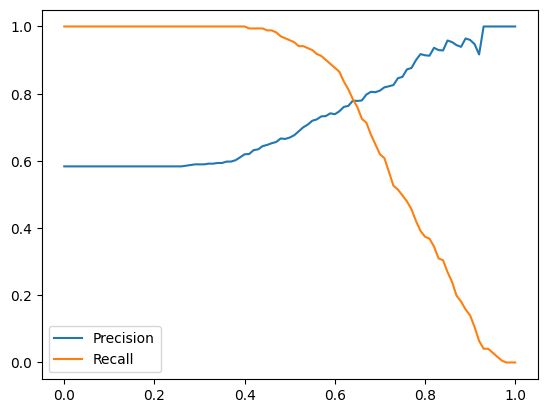

In [29]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [30]:
diff = np.abs(df_scores['precision'] - df_scores['recall'])
idx = diff.idxmin() 

threshold_intersect = df_scores.loc[idx, 'threshold']
print(f"Precision and recall intersect approximately at threshold {threshold_intersect:.3f}")

Precision and recall intersect approximately at threshold 0.640


In [31]:
# 0.64

In [32]:
0.64 - 0.545

0.09499999999999997

In [33]:
0.745 - 0.64

0.10499999999999998

In [34]:
# 0.545

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [35]:
df_scores['f1'] = (2*df_scores.precision*df_scores.recall)/(df_scores.precision+df_scores.recall)

In [36]:
idx_max = df_scores['f1'].idxmax()
threshold_f1_max = df_scores.loc[idx_max, "threshold"]
f1_max = df_scores.loc[idx_max, "f1"]

print(f"Maximum F1 = {f1_max:.2f} at threshold {threshold_f1_max:.2f}.")

Maximum F1 = 0.81 at threshold 0.57.


In [37]:
# 0.54

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [38]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_cols + numerical_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict_prob(df, dv, model):
    dicts = df[categorical_cols + numerical_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_prob = model.predict_proba(X)[:, 1]

    return y_prob

def predict(df, dv, model):
    dicts = df[categorical_cols + numerical_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores1 = []
scores2 = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_prob = predict_prob(df_val, dv, model)
    y_pred = predict(df_val, dv, model)

    auc1 = roc_auc_score(y_val, y_prob)
    auc2 = roc_auc_score(y_val, y_pred)
    scores1.append(auc1)
    scores2.append(auc2)

print(f"Standard deviation = {np.std(scores1):.4f}")
print(f"Standard deviation = {np.std(scores2):.4f}")

Standard deviation = 0.0358
Standard deviation = 0.0248


In [40]:
# 0.06

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [43]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict_prob(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.14it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036


In [44]:
# 0.001